In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=5000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|

    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(4096,)) #changed
    '''
    input_K = Input(shape=(1024,)
    changed Secret Key Embedder 
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1)
    x = concatenate([input_S, x2])
    '''

    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_S, x])
     
    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))

    #changed Adding key
    '''
    input_K = Input(shape=(1024,))
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1) # I think transpposing produces fixed result
    x = concatenate([reveal_input, x2])
    '''

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    input_K = Input(shape=(4096,)) #changed
    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_with_noise, x])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(4096,)) #changed
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE   10587.31 | Loss Rev    7352.54: 100%|██████████| 1563/1563 [06:44<00:00,  3.86it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    4338.83 | Loss Rev    2596.22: 100%|██████████| 1563/1563 [06:34<00:00,  3.96it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    3356.94 | Loss Rev    1851.38: 100%|██████████| 1563/1563 [06:33<00:00,  3.97it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    2840.72 | Loss Rev    1537.36: 100%|██████████| 1563/1563 [06:33<00:00,  3.97it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    2433.42 | Loss Rev    1264.32: 100%|██████████| 1563/1563 [06:33<00:00,  3.97it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    2028.84 | Loss Rev     948.56: 100%|██████████| 1563/1563 [06:32<00:00,  3.98it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1808.73 | Loss Rev     811.89: 100%|██████████| 1563/1563 [06:32<00:00,  3.98it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1776.87 | Loss Rev     788.76: 100%|██████████| 1563/1563 [06:33<00

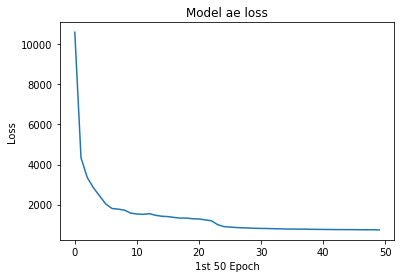

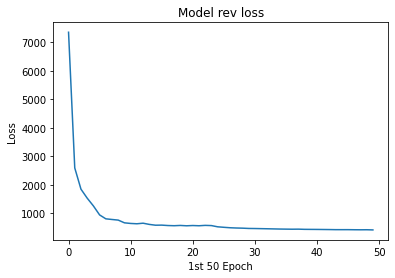

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_50e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Loss')
plt.xlabel('1st 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Loss')
plt.xlabel('1st 50 Epoch')
plt.show()


### Rest 50 epochs:

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_50e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_50e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_50e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1 , idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
      if(epoch == 10):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_60e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_60e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_60e.hdf5')
      if(epoch == 20):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_70e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_70e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_70e.hdf5')
      if(epoch == 30):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_80e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_80e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_80e.hdf5')
      if(epoch == 40):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_90e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_90e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_90e.hdf5')
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE     769.51 | Loss Rev     440.85: 100%|██████████| 1563/1563 [06:36<00:00,  3.94it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE     740.66 | Loss Rev     422.69: 100%|██████████| 1563/1563 [06:30<00:00,  4.01it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE     738.31 | Loss Rev     419.20: 100%|██████████| 1563/1563 [06:30<00:00,  4.00it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE     737.41 | Loss Rev     419.93: 100%|██████████| 1563/1563 [06:30<00:00,  4.00it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE     737.11 | Loss Rev     418.95: 100%|██████████| 1563/1563 [06:25<00:00,  4.06it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE     735.26 | Loss Rev     416.81: 100%|██████████| 1563/1563 [06:25<00:00,  4.06it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE     732.54 | Loss Rev     415.99: 100%|██████████| 1563/1563 [06:26<00:00,  4.04it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE     733.32 | Loss Rev     417.16: 100%|██████████| 1563/1563 [06:28<00

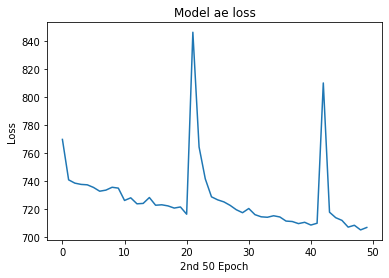

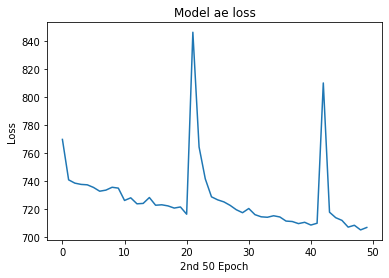

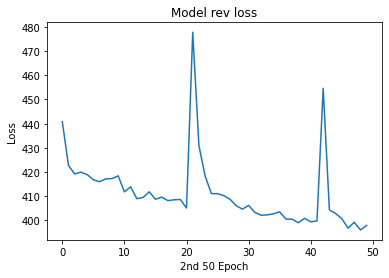

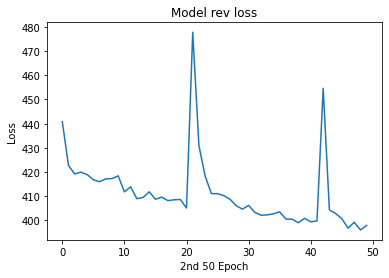

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_100e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_100e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_100e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()

150 epoch

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_100e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_100e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_100e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1 , idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
      if(epoch +1 == 10):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_110e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_110e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_110e.hdf5')
      if(epoch +1 == 20):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_120e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_120e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_120e.hdf5')
      if(epoch +1== 30):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_130e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_130e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_130e.hdf5')
      if(epoch +1== 40):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_140e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_140e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_140e.hdf5')
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE     748.72 | Loss Rev     420.41: 100%|██████████| 1563/1563 [06:40<00:00,  3.90it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE     701.49 | Loss Rev     394.15: 100%|██████████| 1563/1563 [06:30<00:00,  4.01it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE     702.67 | Loss Rev     394.66: 100%|██████████| 1563/1563 [06:30<00:00,  4.00it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE     704.25 | Loss Rev     395.94: 100%|██████████| 1563/1563 [06:31<00:00,  4.00it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE     907.75 | Loss Rev     516.56: 100%|██████████| 1563/1563 [06:35<00:00,  3.95it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE     736.14 | Loss Rev     414.22: 100%|██████████| 1563/1563 [06:33<00:00,  3.97it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE     728.07 | Loss Rev     408.28: 100%|██████████| 1563/1563 [06:31<00:00,  3.99it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE     724.74 | Loss Rev     407.23: 100%|██████████| 1563/1563 [06:30<00

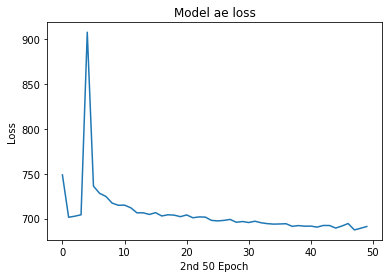

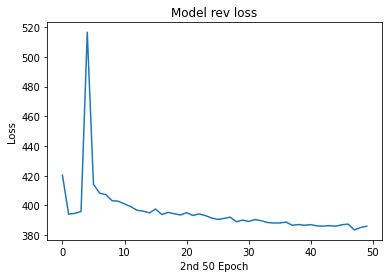

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_150e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_150e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_150e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()

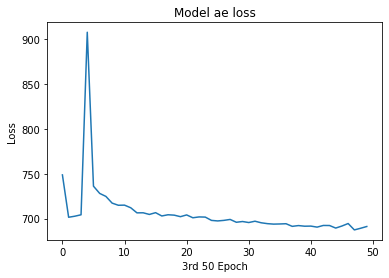

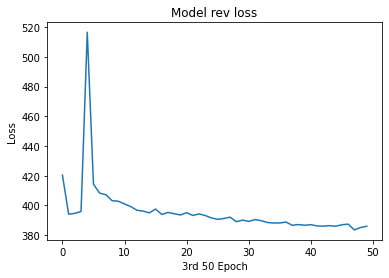

In [ ]:
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Loss')
plt.xlabel('3rd 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Loss')
plt.xlabel('3rd 50 Epoch')
plt.show()

200 epoch


In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_170e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_170e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_170e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1 , idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))

      if(epoch +1== 10):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_180e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_180e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_180e.hdf5')
      if(epoch +1== 20):
        autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_190e.hdf5')
        encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_190e.hdf5')
        reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_190e.hdf5')
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE     714.45 | Loss Rev     402.30: 100%|██████████| 1563/1563 [07:05<00:00,  3.68it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE     686.47 | Loss Rev     383.07: 100%|██████████| 1563/1563 [06:51<00:00,  3.80it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE     688.87 | Loss Rev     385.66: 100%|██████████| 1563/1563 [06:49<00:00,  3.81it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE     686.69 | Loss Rev     383.52: 100%|██████████| 1563/1563 [06:49<00:00,  3.81it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE     688.69 | Loss Rev     383.70: 100%|██████████| 1563/1563 [06:49<00:00,  3.81it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE     684.62 | Loss Rev     382.05: 100%|██████████| 1563/1563 [06:50<00:00,  3.81it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE     685.99 | Loss Rev     382.54: 100%|██████████| 1563/1563 [06:47<00:00,  3.83it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE     686.56 | Loss Rev     383.14: 100%|██████████| 1563/1563 [06:50<00

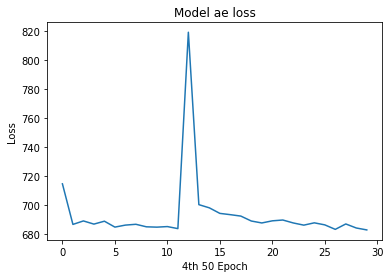

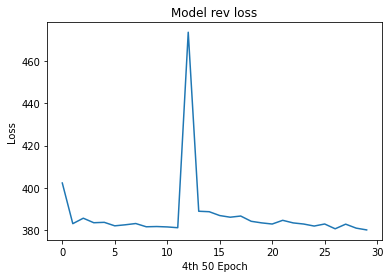

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(30)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_200e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_200e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_200e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Loss')
plt.xlabel('4th 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Loss')
plt.xlabel('4th 50 Epoch')
plt.show()

Stego Expose

In [ ]:
from google.colab import files
from cv2 import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib 
np.random.seed(22)
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_200e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_200e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_200e.hdf5')
secret=X_test[0:2000]
cover=X_test[2000:4000]

test_actual_K = np.random.randint(2, size=(2000,4096))
C_prime = encoder_model.predict([secret, cover, test_actual_K])
i=1

for c in tqdm(cover):
  matplotlib.image.imsave('/content/drive/My Drive/Stegoexpose/Sym_autoencoder_model_100k_200e/clean/clean_'+str(i)+'.png',c)
  i= i+1

i=1
for s in tqdm(C_prime):
  s = s.clip(min = 0, max =1)
  matplotlib.image.imsave('/content/drive/My Drive/Stegoexpose/Sym_autoencoder_model_100k_200e/stego/stego_'+str(i)+'.png',s)
  i= i+1

In [ ]:
!pip install scikit-plot

[[0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1],

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


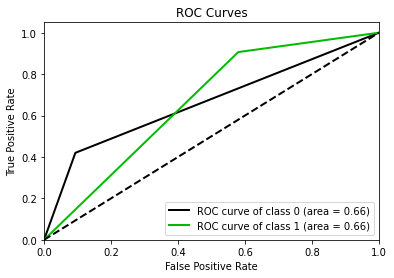

In [ ]:

import pandas

data = pandas.read_csv("/content/drive/My Drive/Stegoexpose/steganalysisOfTestFolder1.csv", header=0)
y_true = list(data.True_Label)
y_pro = list(data.Predict)
y_probas =[]
for i in y_pro:
  if i==1:
    y_probas.append([0,1])
  else:
    y_probas.append([1,0])
print(y_probas)

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_true,y_probas,curves =('each_class'),)
s
plt.show()



### *Wrong* Key

In [ ]:

encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_200e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_200e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_200e.hdf5')
secret=X_test[2]
cover=X_test[3]
test_actual_K = np.random.randint(2, size=(1,4096))
test_wrong_K = np.random.randint(2, size=(1, 4096))
C_prime = encoder_model.predict([np.array([secret]), np.array([cover]), test_actual_K])
print(C_prime.shape)
Reveal_actual = reveal_model.predict([C_prime, test_actual_K])
Reveal_wrong = reveal_model.predict([C_prime, test_wrong_K])


(1, 64, 64, 3)


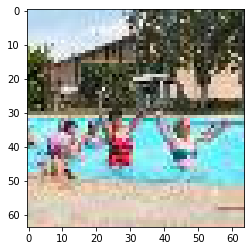

In [ ]:
plt.imshow(secret)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


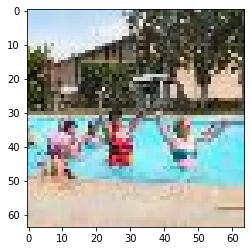

In [ ]:
plt.imshow(Reveal_actual[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


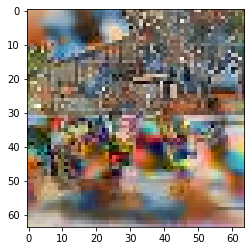

In [ ]:
plt.imshow(Reveal_wrong[0])
plt.show()

Cover and Stego image difference

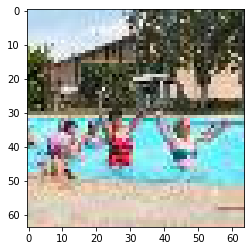

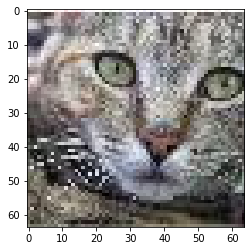

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


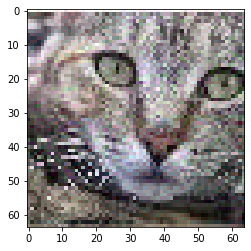

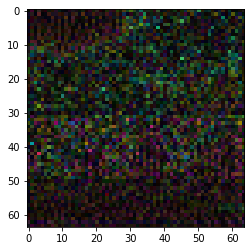

In [ ]:
diff_stego_cover =np.abs(C_prime[0] - cover)
plt.imshow(secret)
plt.show()
plt.imshow(cover)
plt.show()
plt.imshow(C_prime[0])
plt.show()
plt.imshow(diff_stego_cover*5)
plt.show()

In [ ]:
n_row=1
n_col=4
i=0
def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)

    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))


show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')


plt.show()

### Test and Result

In [ ]:
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
# Retrieve decoded predictions.
np.random.seed(22) 
test_K = np.random.randint(2, size=(len(input_S), 4096))

decoded = autoencoder_model.predict([input_S, input_C, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=True, alpha=0.75, color='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=True, alpha=0.75, color='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 12.214547
C error per pixel [0, 255]: 12.824105


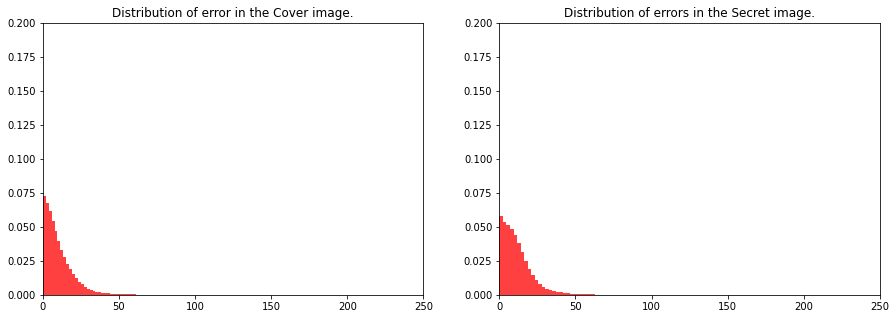

In [ ]:
pixel_histogram(diff_S, diff_C)

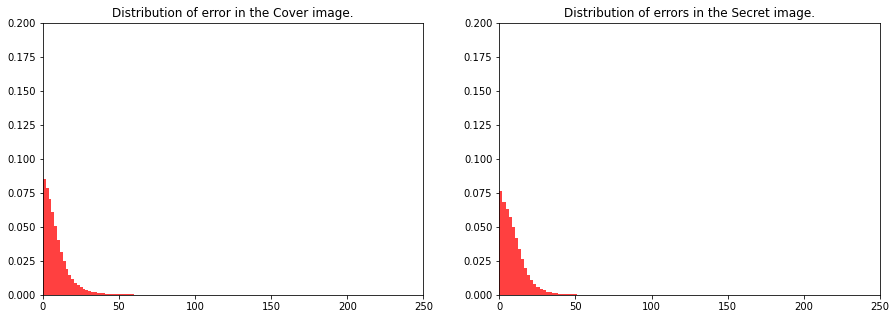

In [ ]:
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


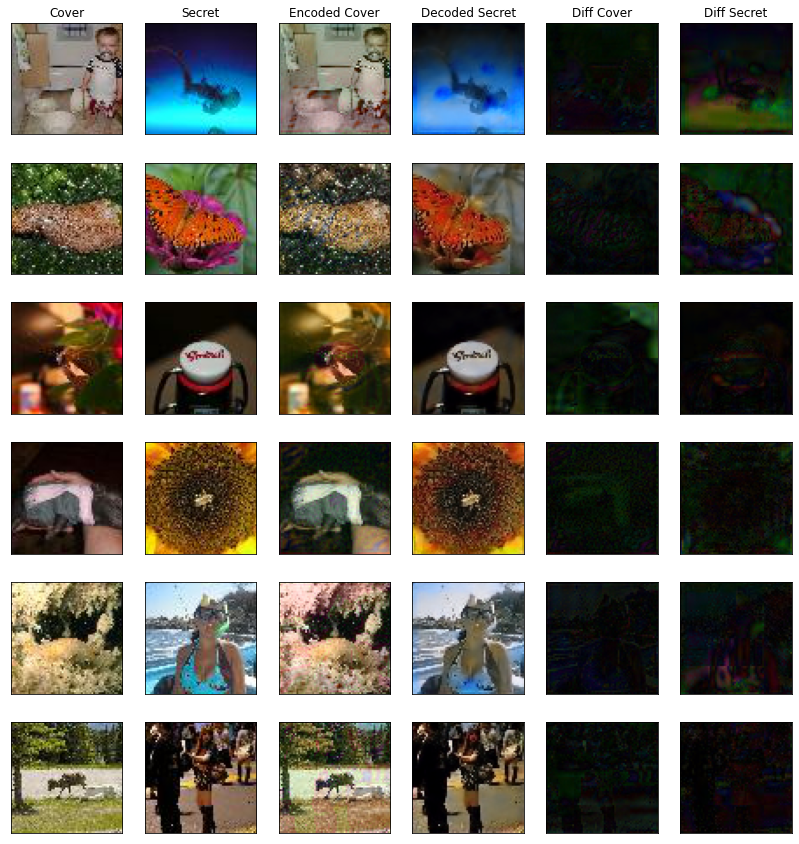

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

### Train with mix loss from paper

In [ ]:
from scipy.ndimage import gaussian_filter
def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
alpha = 0.84
def mix_loss(y_true, y_pred) :
  mssim_loss = 1 - tf.image.ssim_multiscale(y_true, y_pred, max_val = 1.0,filter_size=4)
  l1_loss = tf.math.reduce_mean(gaussian_blur(tf.abs(y_true - y_pred),kernel_size=5, sigma =1))
  return alpha * mssim_loss + (1-alpha) * l1_loss


# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    #return beta * K.sum(K.square(y_true - y_pred))
    return mix_loss(y_true, y_pred) 

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    s_loss = rev_loss(s_true, s_pred)
    c_loss = rev_loss(c_true, c_pred)
    return s_loss + c_loss

# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(4096,)) #changed
    '''
    input_K = Input(shape=(1024,)
    changed Secret Key Embedder 
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1)
    x = concatenate([input_S, x2])
    '''

    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_S, x])
     
    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))

    #changed Adding key
    '''
    input_K = Input(shape=(1024,))
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1) # I think transpposing produces fixed result
    x = concatenate([reveal_input, x2])
    '''

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    input_K = Input(shape=(4096,)) #changed
    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_with_noise, x])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(4096,)) #changed
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE       0.17 | Loss Rev       0.11: 100%|██████████| 1563/1563 [07:59<00:00,  3.26it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE       0.12 | Loss Rev       0.08: 100%|██████████| 1563/1563 [07:23<00:00,  3.52it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE       0.09 | Loss Rev       0.06: 100%|██████████| 1563/1563 [07:27<00:00,  3.50it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE       0.08 | Loss Rev       0.04: 100%|██████████| 1563/1563 [07:27<00:00,  3.49it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE       0.07 | Loss Rev       0.04: 100%|██████████| 1563/1563 [07:27<00:00,  3.50it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE       0.07 | Loss Rev       0.04: 100%|██████████| 1563/1563 [07:26<00:00,  3.50it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE       0.06 | Loss Rev       0.03: 100%|██████████| 1563/1563 [07:26<00:00,  3.50it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE       0.06 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:26<00

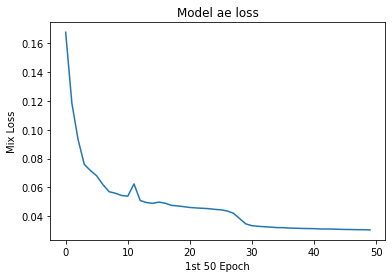

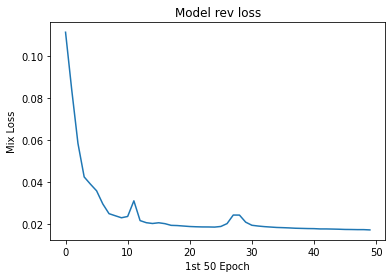

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_50e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Mix Loss')
plt.xlabel('1st 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Mix Loss')
plt.xlabel('1st 50 Epoch')
plt.show()


2nd 50 epoch

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_50e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_50e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_50e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1 , idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))

  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:33<00:00,  3.45it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:05<00:00,  3.68it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:04<00:00,  3.68it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:03<00:00,  3.69it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:02<00:00,  3.70it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:03<00:00,  3.69it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:02<00:00,  3.70it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:02<00

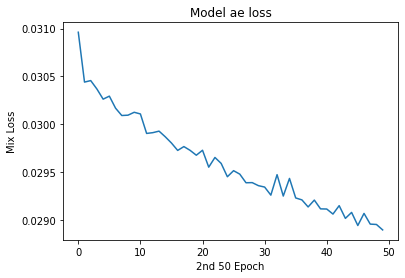

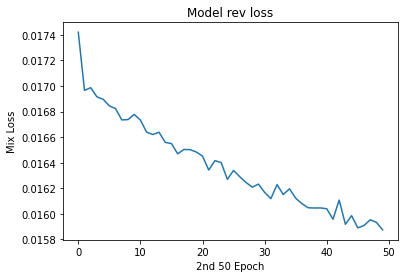

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_100e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_100e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_100e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Mix Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Mix Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_100e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_100e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_100e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1 , idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))

  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [08:06<00:00,  3.21it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:33<00:00,  3.45it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:33<00:00,  3.45it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:31<00:00,  3.46it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:32<00:00,  3.46it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:33<00:00,  3.45it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:33<00:00,  3.45it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:33<00

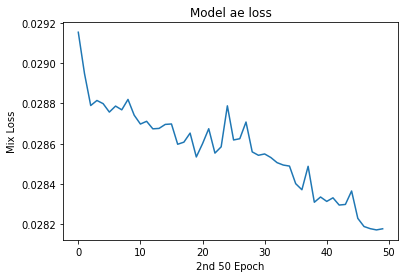

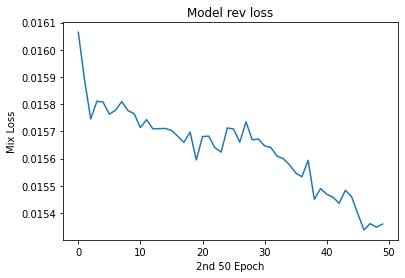

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_150e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_150e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_150e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Mix Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Mix Loss')
plt.xlabel('2nd 50 Epoch')
plt.show()

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_150e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_150e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_150e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1 , idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))

  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [06:55<00:00,  3.76it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [06:55<00:00,  3.76it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [06:55<00:00,  3.76it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [06:56<00:00,  3.76it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [06:56<00:00,  3.76it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [06:56<00:00,  3.75it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE       0.03 | Loss Rev       0.02: 100%|██████████| 1563/1563 [06:57<00

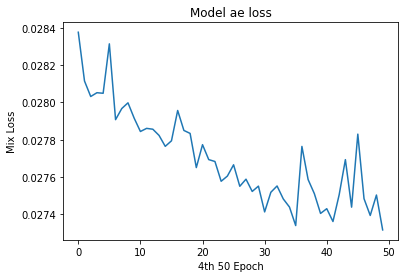

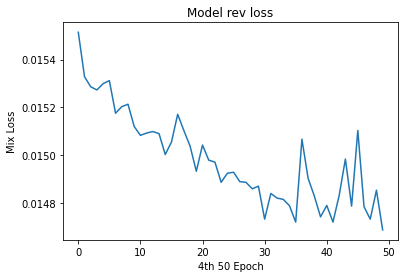

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_200e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_200e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_200e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Mix Loss')
plt.xlabel('4th 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Mix Loss')
plt.xlabel('4th 50 Epoch')
plt.show()

In [ ]:
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
# Retrieve decoded predictions.
np.random.seed(22) 
test_K = np.random.randint(2, size=(len(input_S), 4096))
decoded = autoencoder_model.predict([input_S, input_C, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=True, alpha=0.75, color='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=True, alpha=0.75, color='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 24.475437
C error per pixel [0, 255]: 12.532917


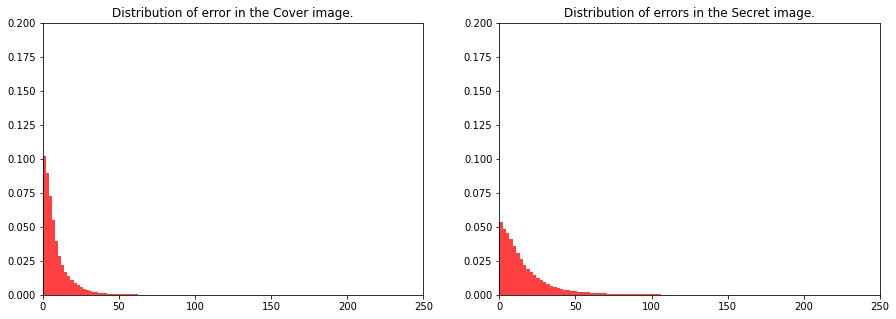

In [ ]:
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


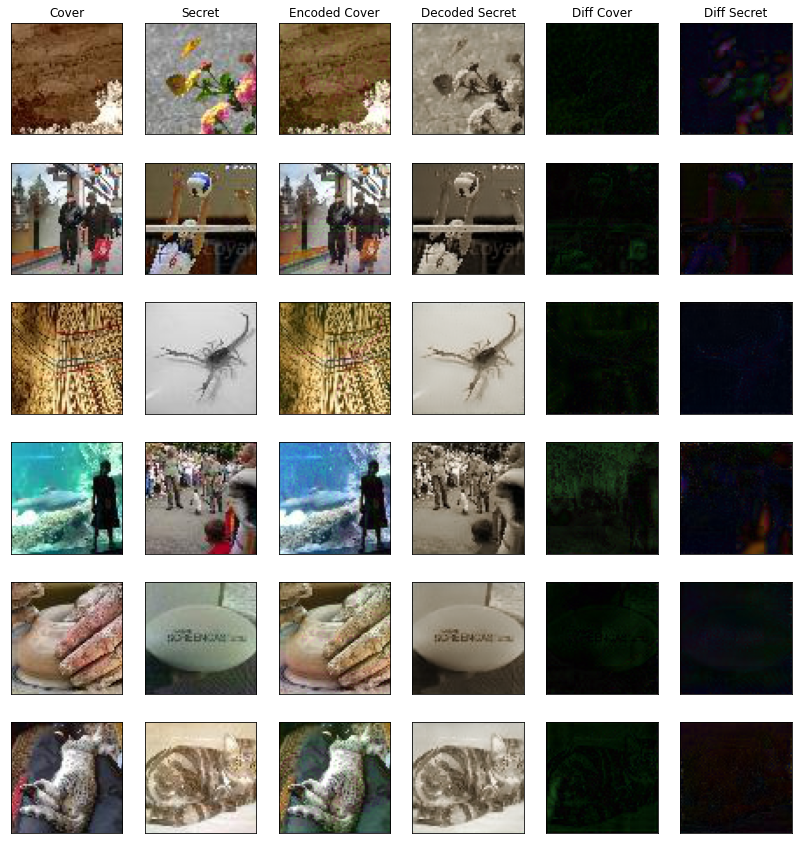

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

## Comparison between mix loss and sse loss

In [ ]:
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

### mix_loss

In [ ]:
# Retrieve decoded predictions.
np.random.seed(22) 
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_200e.hdf5')
test_K = np.random.randint(2, size=(len(input_S), 4096))
decoded = autoencoder_model.predict([input_S, input_C, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 6.9923415
C error per pixel [0, 255]: 10.382385


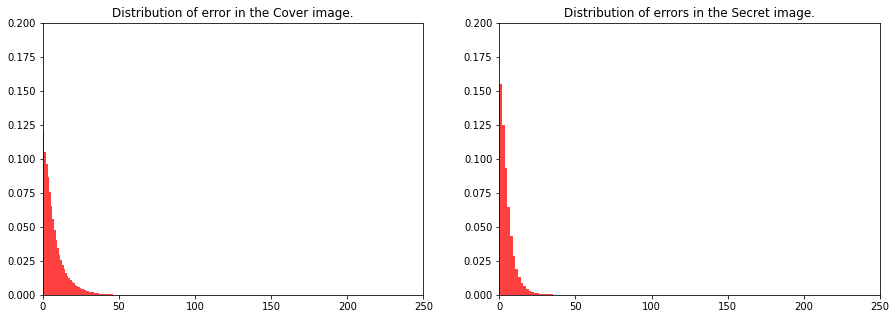

In [ ]:
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

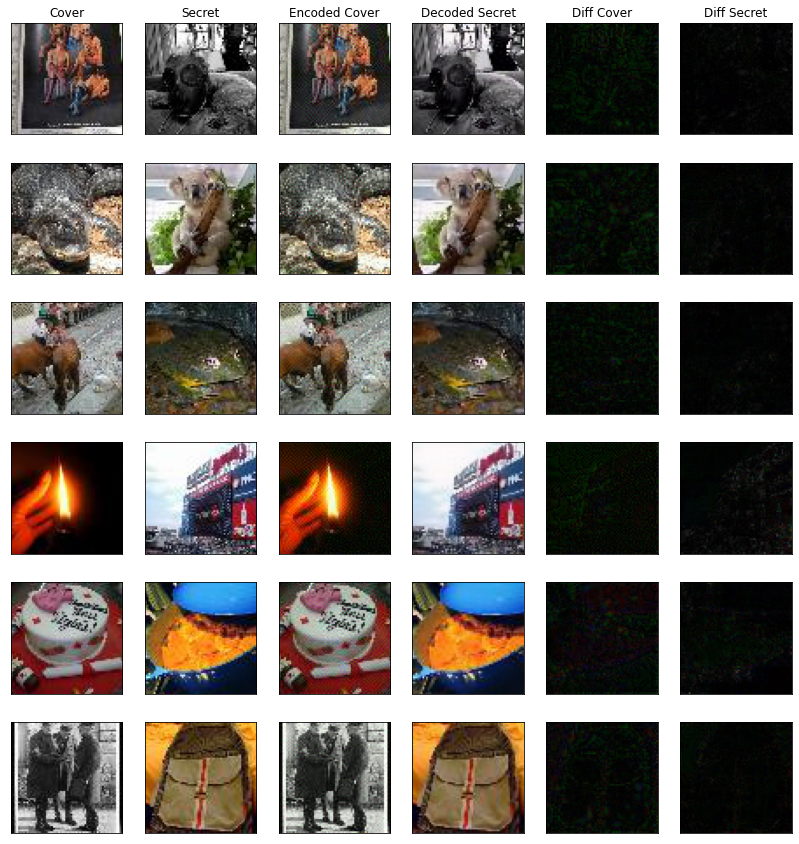

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

In [ ]:
tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.97240496>

In [ ]:
tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=31.848637>

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_200e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_mix_loss_100k_200e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_mix_loss_100k_200e.hdf5')
secret=X_test[2]
cover=X_test[3]
test_actual_K = np.random.randint(2, size=(1,4096))
test_wrong_K = np.random.randint(2, size=(1, 4096))
C_prime = encoder_model.predict([np.array([secret]), np.array([cover]), test_actual_K])
print(C_prime.shape)
Reveal_actual = reveal_model.predict([C_prime, test_actual_K])
Reveal_wrong = reveal_model.predict([C_prime, test_wrong_K])

(1, 64, 64, 3)


### sse_loss

In [ ]:
# Retrieve decoded predictions.
np.random.seed(22) 
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_200e.hdf5')
test_K = np.random.randint(2, size=(len(input_S), 4096))
decoded = autoencoder_model.predict([input_S, input_C, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 4.6302195
C error per pixel [0, 255]: 7.3495684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

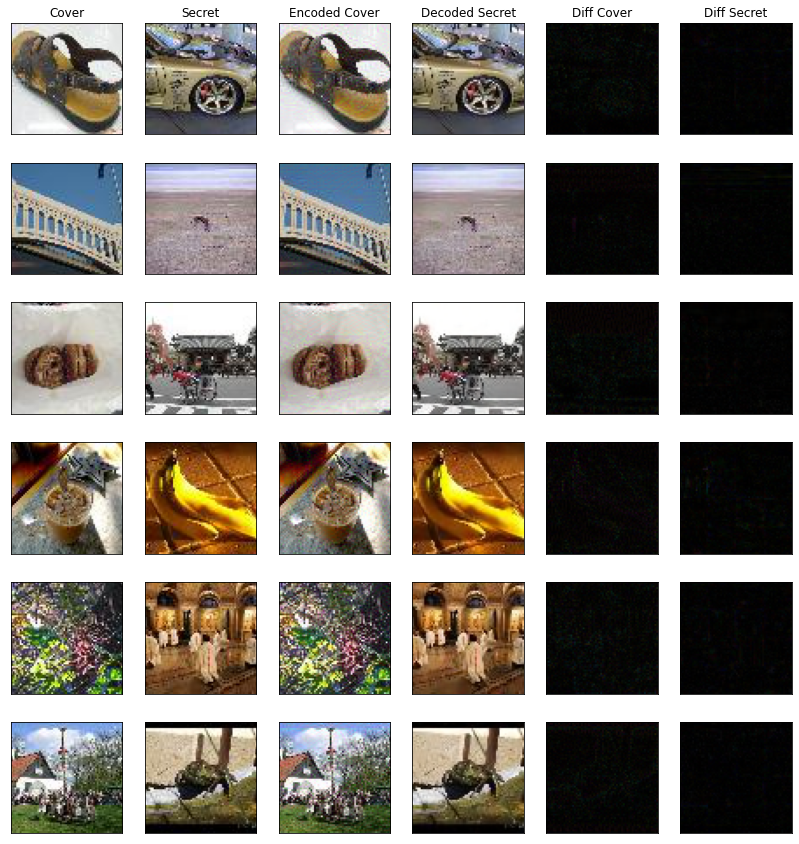

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

In [ ]:
tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.97457755>

In [ ]:
tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=35.269207>

### 50 epoch of mix_loss :

In [ ]:
# Retrieve decoded predictions.
np.random.seed(22) 
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_mix_loss_100k_50e.hdf5')
test_K = np.random.randint(2, size=(len(input_S), 4096))
decoded = autoencoder_model.predict([input_S, input_C, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 9.823427
C error per pixel [0, 255]: 10.729504


In [ ]:
tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9578409>

In [ ]:
tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8896414>

In [ ]:
tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=28.633135>

In [ ]:
tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=27.766603>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

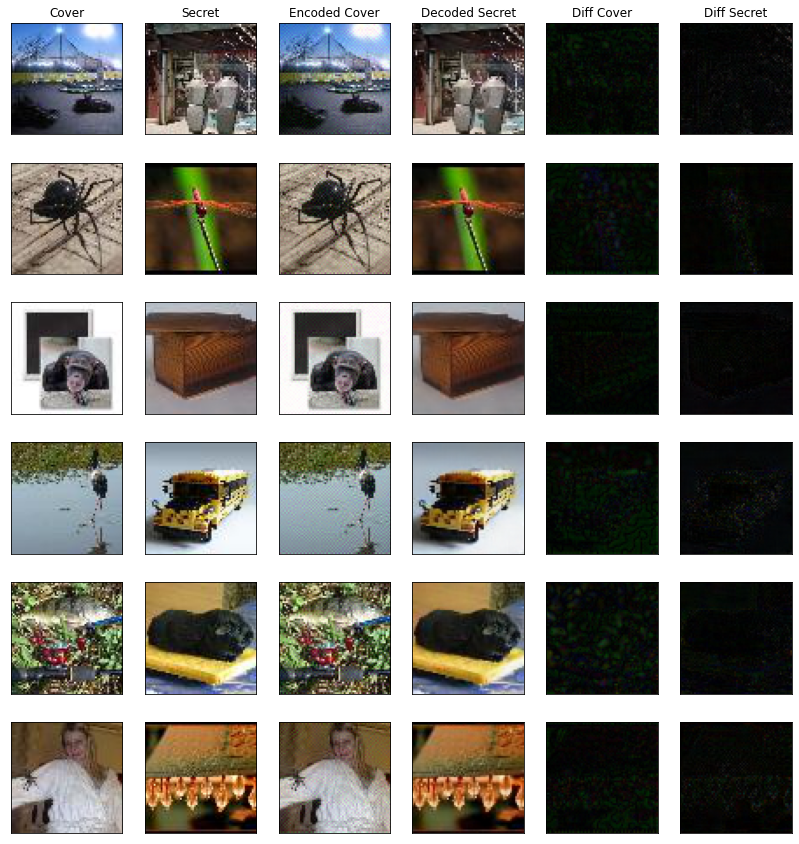

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

### 50 epoch of sse loss :


In [ ]:
# Retrieve decoded predictions.
np.random.seed(22) 
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_50e.hdf5')
test_K = np.random.randint(2, size=(len(input_S), 4096))
decoded = autoencoder_model.predict([input_S, input_C, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 5.1776166
C error per pixel [0, 255]: 7.42531


In [ ]:
tf.reduce_mean(tf.image.ssim(input_S, decoded_S, 1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9718958>

In [ ]:
tf.reduce_mean(tf.image.ssim(input_C, decoded_C, 1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9168207>

In [ ]:
tf.reduce_mean(tf.image.psnr(input_S, decoded_S, max_val=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=34.344746>

In [ ]:
tf.reduce_mean(tf.image.psnr(input_C, decoded_C, max_val=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=30.990974>

## Punishing on wrong key

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def custom_rev_loss(wrong_S):
  def rev_loss(y_true, y_pred):
      # Loss for reveal network is: beta * |S-S'|
      return K.sum(K.square(y_true - y_pred)) + K.sum(K.square(wrong_S))
  return rev_loss

# Loss for the full model, used for preparation and hidding networks
def custom_full_loss(wrong_S):
  def full_loss(y_true, y_pred):
      # Loss for the full model is: |C-C'| + beta * |S-S'|
      s_true, c_true = y_true[...,0:3], y_true[...,3:6]
      s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
      s_loss = K.sum(K.square(s_true - s_pred)) + K.sum(K.square(wrong_S))
      c_loss = K.sum(K.square(c_true - c_pred))
      return s_loss + c_loss
  return full_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    wrong_S= Input(shape=(input_size))
    input_K = Input(shape=(4096,)) #changed
    '''
    input_K = Input(shape=(1024,)
    changed Secret Key Embedder 
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1)
    x = concatenate([input_S, x2])
    '''

    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_S, x])
     
    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C, wrong_S, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    wrong_S= Input(shape=(input_size))

    #changed Adding key
    '''
    input_K = Input(shape=(1024,))
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1) # I think transpposing produces fixed result
    x = concatenate([reveal_input, x2])
    '''

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    input_K = Input(shape=(4096,)) #changed
    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_with_noise, x])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=[reveal_input, wrong_S, input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,wrong_S,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(4096,)) #changed
    wrong_S= Input(shape=(input_size))
    encoder = make_encoder(input_size)
    
    
    # Reveal network
    reveal_input = Input(shape=(input_size))

    #changed Adding key
    '''
    input_K = Input(shape=(1024,))
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1) # I think transpposing produces fixed result
    x = concatenate([reveal_input, x2])
    '''

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    input_K = Input(shape=(4096,)) #changed
    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_with_noise, x])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
  
    decoder = Model(inputs=[reveal_input, wrong_S, input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
  
    decoder.compile(optimizer='adam',experimental_run_tf_function=False, loss=custom_rev_loss(wrong_S))
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, wrong_S, input_K]) #changed
    output_Sprime = decoder([output_Cprime, wrong_S, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, wrong_S, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam',experimental_run_tf_function=False, loss=custom_full_loss(wrong_S))
    return encoder, decoder, autoencoder

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          wrong_batch_K = batch_K

          for i in range(len(batch_S)):
            bit_no = np.random.randint(4096, size=1)
            wrong_batch_K[i, bit_no] = 1 - wrong_batch_K[i, bit_no]
          
          wrong_S  = np.zeros(shape=(len(batch_S),64,64,3))
          
          C_prime = encoder_model.predict([batch_S, batch_C,wrong_S, batch_K])
          wrong_S = reveal_model.predict([C_prime, wrong_S, wrong_batch_K])      
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, wrong_S, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime, wrong_S, batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1 | Batch: 49984 of 50000. Loss AE  110373.77 | Loss Rev  107249.03: 100%|██████████| 1563/1563 [06:31<00:00,  3.99it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE  108258.58 | Loss Rev  106898.55: 100%|██████████| 1563/1563 [05:53<00:00,  4.42it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE  107986.61 | Loss Rev  106803.41: 100%|██████████| 1563/1563 [05:53<00:00,  4.42it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE  107898.52 | Loss Rev  106755.32: 100%|██████████| 1563/1563 [05:53<00:00,  4.42it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE  107791.63 | Loss Rev  106720.95: 100%|██████████| 1563/1563 [05:53<00:00,  4.42it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE  107815.35 | Loss Rev  106732.88: 100%|██████████| 1563/1563 [05:53<00:00,  4.43it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE  107727.31 | Loss Rev  106724.79: 100%|██████████| 1563/1563 [05:53<00:00,  4.43it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE  107726.33 | Loss Rev  106743.99: 100%|██████████| 1563/1563 [05:53<00

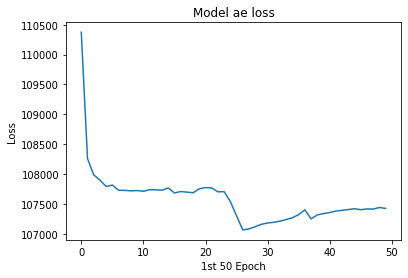

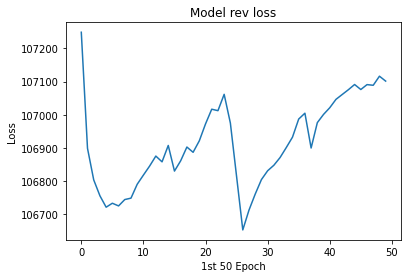

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_wrong_key_model_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_wrong_key_model_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_wrong_key_model_100k_50e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Loss')
plt.xlabel('1st 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Loss')
plt.xlabel('1st 50 Epoch')
plt.show()

In [ ]:
import keras.backend as K
K.clear_session()

In [ ]:
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
# Retrieve decoded predictions.
np.random.seed(22) 
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_wrong_key_model_100k_50e.hdf5')
test_K = np.random.randint(2, size=(len(input_S), 4096))
wrong_S  = np.zeros(shape=(len(input_S),64,64,3))
decoded = autoencoder_model.predict([input_S, input_C, wrong_S, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 5.1312437
C error per pixel [0, 255]: 7.3247414


In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_wrong_key_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_wrong_key_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_wrong_key_model_100k_50e.hdf5')
secret=X_test[0]
cover=X_test[1]
wrong_S  = np.zeros(shape=(1,64,64,3))
test_actual_K = np.random.randint(2, size=(1,4096))
test_wrong_K = np.random.randint(2, size=(1,4096))
#for i in range(4096) :
    #test_wrong_K[0][i] = 1-test_actual_K[0][i]
#test_wrong_K[0][6] = 1-test_actual_K[0][6]
C_prime = encoder_model.predict([np.array([secret]), np.array([cover]),wrong_S, test_actual_K])
print(C_prime.shape)
Reveal_actual = reveal_model.predict([C_prime, wrong_S, test_actual_K])
Reveal_wrong = reveal_model.predict([C_prime,wrong_S, test_wrong_K])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1, 64, 64, 3)


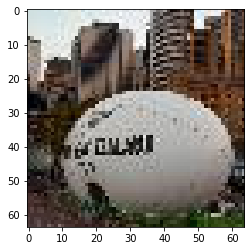

In [ ]:
plt.imshow(secret)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


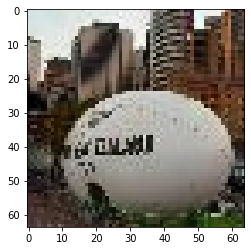

In [ ]:
plt.imshow(Reveal_actual[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


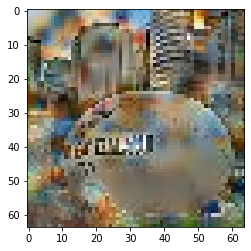

In [ ]:
plt.imshow(Reveal_wrong[0])
plt.show()

### Punishing on several wrong key

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def custom_rev_loss(wrong_S):
  def rev_loss(y_true, y_pred):
      # Loss for reveal network is: beta * |S-S'|
      return K.sum(K.square(y_true - y_pred)) + K.sum(K.square(wrong_S))
  return rev_loss

# Loss for the full model, used for preparation and hidding networks
def custom_full_loss(wrong_S):
  def full_loss(y_true, y_pred):
      # Loss for the full model is: |C-C'| + beta * |S-S'|
      s_true, c_true = y_true[...,0:3], y_true[...,3:6]
      s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
      s_loss = K.sum(K.square(s_true - s_pred)) + K.sum(K.square(wrong_S))
      c_loss = K.sum(K.square(c_true - c_pred))
      return s_loss + c_loss
  return full_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    wrong_S= Input(shape=(input_size))
    input_K = Input(shape=(4096,)) #changed
    '''
    input_K = Input(shape=(1024,)
    changed Secret Key Embedder 
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1)
    x = concatenate([input_S, x2])
    '''

    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_S, x])
     
    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C, wrong_S, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    wrong_S= Input(shape=(input_size))

    #changed Adding key
    '''
    input_K = Input(shape=(1024,))
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1) # I think transpposing produces fixed result
    x = concatenate([reveal_input, x2])
    '''

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    input_K = Input(shape=(4096,)) #changed
    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_with_noise, x])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=[reveal_input, wrong_S, input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,wrong_S,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(4096,)) #changed
    wrong_S= Input(shape=(input_size))
    encoder = make_encoder(input_size)
    
    
    # Reveal network
    reveal_input = Input(shape=(input_size))

    #changed Adding key
    '''
    input_K = Input(shape=(1024,))
    x1 = Reshape((32, 32, 1))(input_K)
    x2 = Conv2DTranspose(3, (2,2), strides = (2,2), activation="relu", name='convtrans_key0_2x2')(x1) # I think transpposing produces fixed result
    x = concatenate([reveal_input, x2])
    '''

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed

    input_K = Input(shape=(4096,)) #changed
    x = Reshape((64, 64, 1))(input_K)
    x = concatenate([input_with_noise, x])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
  
    decoder = Model(inputs=[reveal_input, wrong_S, input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
  
    decoder.compile(optimizer='adam',experimental_run_tf_function=False, loss=custom_rev_loss(wrong_S))
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, wrong_S, input_K]) #changed
    output_Sprime = decoder([output_Cprime, wrong_S, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, wrong_S, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam',experimental_run_tf_function=False, loss=custom_full_loss(wrong_S))
    return encoder, decoder, autoencoder

In [ ]:
def Train(e):
  NB_EPOCHS = e
  BATCH_SIZE = 32
  import numpy as np
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.random.randint(2, size=(len(batch_S), 4096))
          wrong_batch_K = np.random.randint(2, size=(len(batch_S), 4096))

          # for i in range(len(batch_S)):
          #   bit_no = np.random.randint(4096, size=1)
          #   wrong_batch_K[i, bit_no] = 1 - wrong_batch_K[i, bit_no]
          
          wrong_S  = np.zeros(shape=(len(batch_S),64,64,3))
          
          C_prime = encoder_model.predict([batch_S, batch_C,wrong_S, batch_K])
          wrong_S = reveal_model.predict([C_prime, wrong_S, wrong_batch_K])      
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, wrong_S, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime, wrong_S, batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1 | Batch: 49984 of 50000. Loss AE  113159.95 | Loss Rev  108599.34: 100%|██████████| 1563/1563 [06:42<00:00,  3.88it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE  109589.28 | Loss Rev  107738.29: 100%|██████████| 1563/1563 [06:04<00:00,  4.29it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE  109276.76 | Loss Rev  107634.54: 100%|██████████| 1563/1563 [06:04<00:00,  4.29it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE  108956.97 | Loss Rev  107628.37: 100%|██████████| 1563/1563 [06:03<00:00,  4.30it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE  108095.14 | Loss Rev  106874.25: 100%|██████████| 1563/1563 [06:03<00:00,  4.30it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE  106958.23 | Loss Rev  105807.56: 100%|██████████| 1563/1563 [06:03<00:00,  4.30it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE  106249.09 | Loss Rev  105156.95: 100%|██████████| 1563/1563 [06:03<00:00,  4.30it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE  106121.17 | Loss Rev  105048.45: 100%|██████████| 1563/1563 [06:03<00

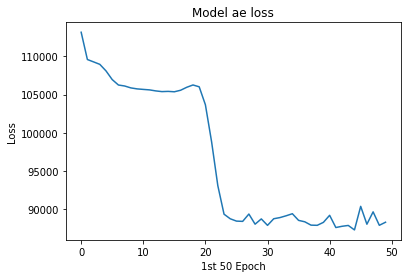

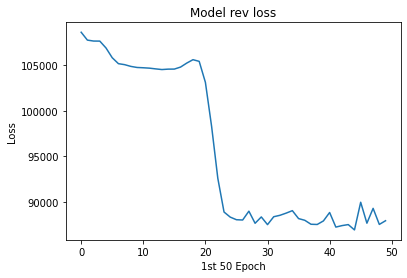

In [ ]:
ae_loss_history, rev_loss_history,encoder_model, reveal_model, autoencoder_model = Train(50)
autoencoder_model.save_weights('/content/drive/My Drive/Model/Sym_autoencoder_wrong_key_several_bits_model_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Model/Sym_encoder_wrong_keys_everal_bits_model_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Model/Sym_reveal_wrong_key_several_bits_model_100k_50e.hdf5')
plt.plot(ae_loss_history)
plt.title('Model ae loss')
plt.ylabel('Loss')
plt.xlabel('1st 50 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model rev loss')
plt.ylabel('Loss')
plt.xlabel('1st 50 Epoch')
plt.show()

In [ ]:
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
np.random.seed(22) 
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_wrong_key_several_bits_model_100k_50e.hdf5')
test_K = np.random.randint(2, size=(len(input_S), 4096))
wrong_S  = np.zeros(shape=(len(input_S),64,64,3))
decoded = autoencoder_model.predict([input_S, input_C, wrong_S, test_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_wrong_key_several_bits_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_wrong_keys_everal_bits_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_wrong_key_several_bits_model_100k_50e.hdf5')
secret=X_test[6]
cover=X_test[7]
wrong_S  = np.zeros(shape=(1,64,64,3))
test_actual_K = np.random.randint(2, size=(1,4096))
test_wrong_K = np.random.randint(2, size=(1,4096))
#for i in range(4096) :
    #test_wrong_K[0][i] = 1-test_actual_K[0][i]
#test_wrong_K[0][6] = 1-test_actual_K[0][6]
C_prime = encoder_model.predict([np.array([secret]), np.array([cover]),wrong_S, test_actual_K])
print(C_prime.shape)
Reveal_actual = reveal_model.predict([C_prime, wrong_S, test_actual_K])
Reveal_wrong = reveal_model.predict([C_prime,wrong_S, test_wrong_K])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1, 64, 64, 3)


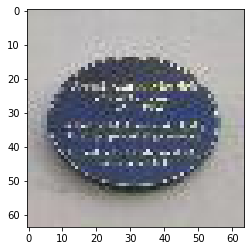

In [ ]:
plt.imshow(cover)
plt.show()

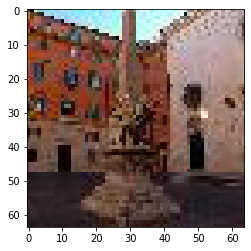

In [ ]:
plt.imshow(secret)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


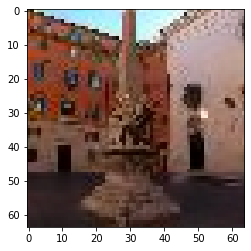

In [ ]:
plt.imshow(Reveal_actual[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


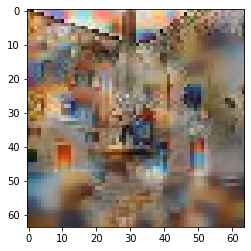

In [ ]:
plt.imshow(Reveal_wrong[0])
plt.show()

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Model/Sym_autoencoder_model_100k_200e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Model/Sym_encoder_model_100k_200e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Model/Sym_reveal_model_100k_200e.hdf5')
secret=X_test[6]
cover=X_test[7]
test_actual_K = np.random.randint(2, size=(1,4096))
test_wrong_K = np.random.randint(2, size=(1, 4096))
C_prime = encoder_model.predict([np.array([secret]), np.array([cover]), test_actual_K])
print(C_prime.shape)
Reveal_actual = reveal_model.predict([C_prime, test_actual_K])
Reveal_wrong = reveal_model.predict([C_prime, test_wrong_K])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


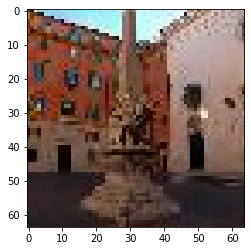

In [ ]:
plt.imshow(Reveal_actual[0])
plt.show()

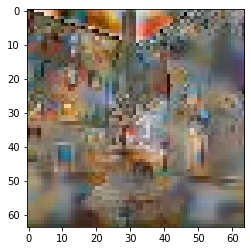

In [ ]:
plt.imshow(Reveal_wrong[0])
plt.show()